# Исследование объявлений о продаже квартир

**Цель исследования:** Используя данные сервиса Яндекс.Недвижимость, определить рыночную стоимость объектов недвижимости и типичные параметры квартир

### Изучим общую информацию.

In [1]:
#подключаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

#настроим вывод
pd.options.display.float_format = '{:,}'.format
pd.set_option('display.max_columns', None)

#отключим предупреждения
import warnings
warnings.filterwarnings('ignore')

In [2]:
#загружаем данные в датафрейм
data = pd.read_csv('C:/Users/aleks/practicum/datasets/real_estate_data.csv', sep='\t')

#посмотрим общую информацию о датафрейме
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.0",108.0,2019-03-07T00:00:00,3,2.7,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,"18,863.0","16,028.0",1.0,482.0,2.0,755.0,NaN
1,7,"3,350,000.0",40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,"12,817.0","18,603.0",0.0,NaN,0.0,NaN,81.0
2,10,"5,196,000.0",56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,"21,741.0","13,933.0",1.0,90.0,2.0,574.0,558.0
3,0,"64,900,000.0",159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,"28,098.0","6,800.0",2.0,84.0,3.0,234.0,424.0
4,2,"10,000,000.0",100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,"31,856.0","8,098.0",2.0,112.0,1.0,48.0,121.0


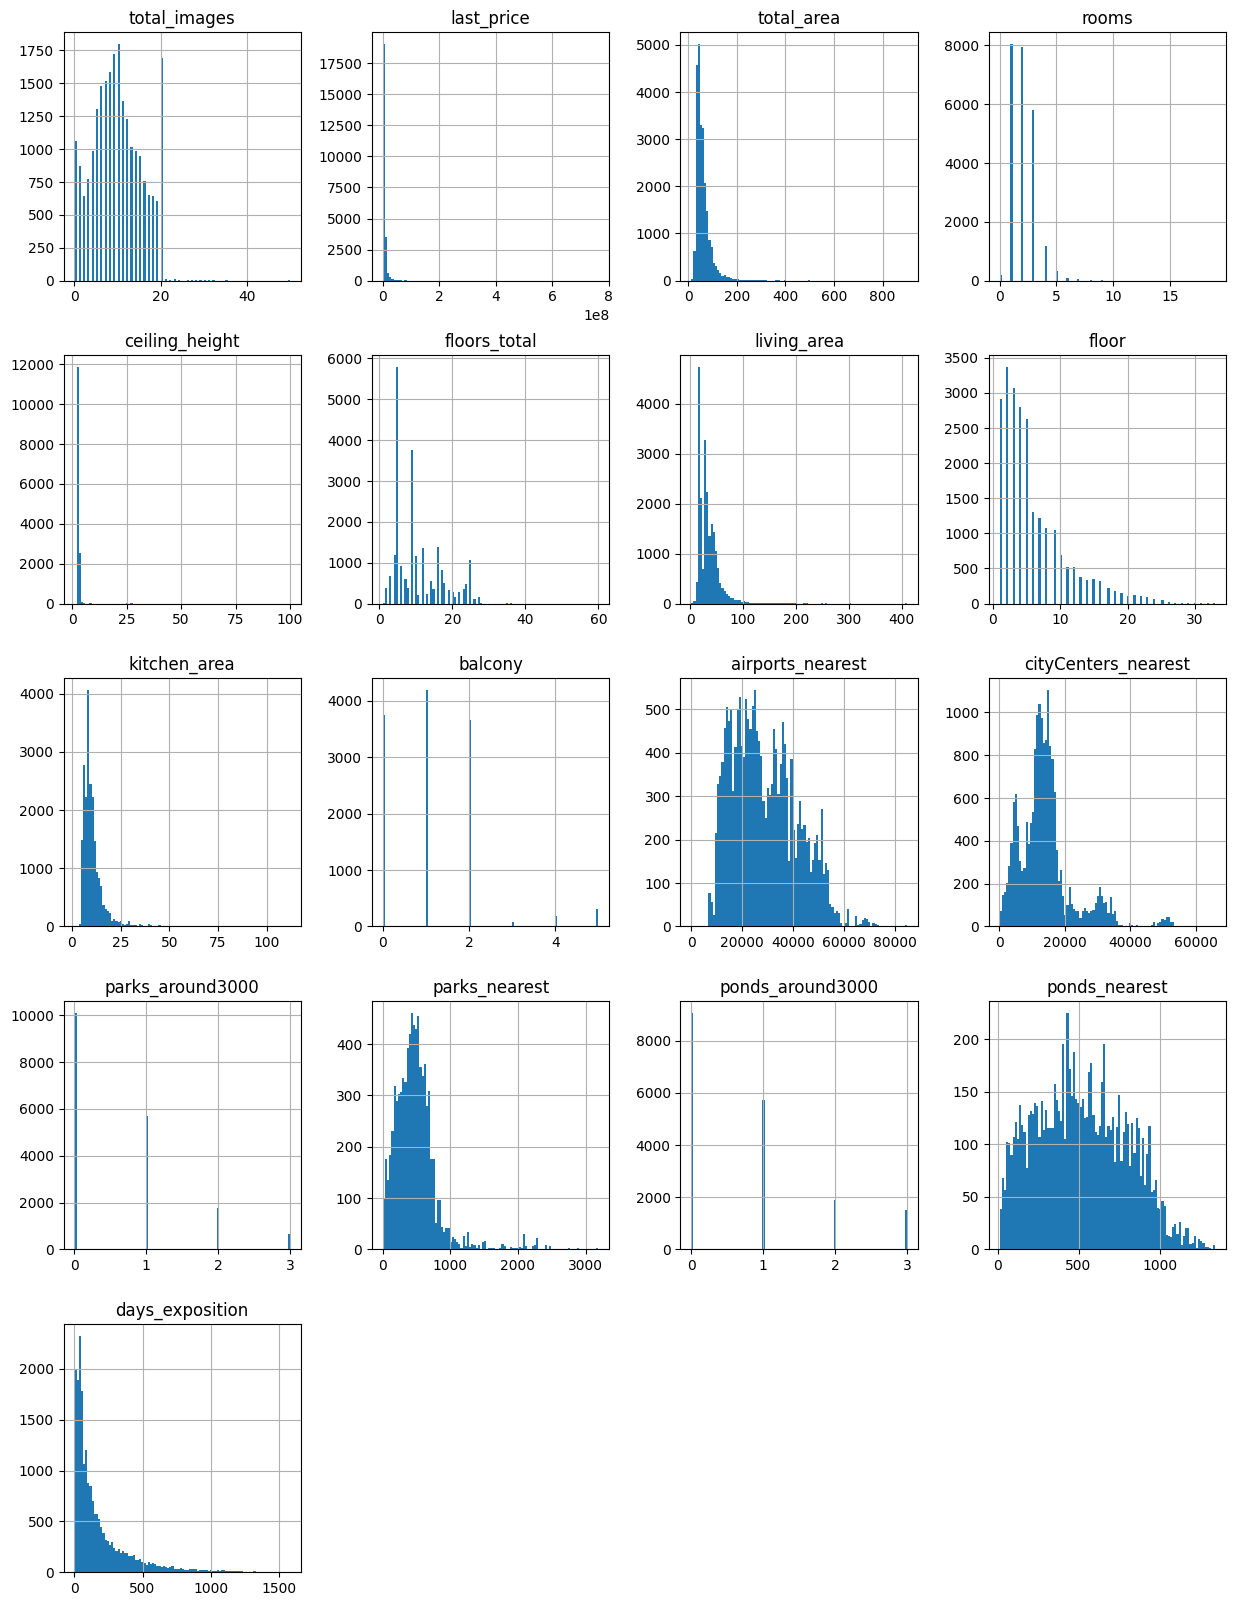

In [3]:
data.hist(figsize=(15, 20), bins = 100);

**Вывод:**
Пока на основании этих данных возможно сделать выводы лишь об общей структуре датафрейма, о наличии дискретных величин в столбцах, а также об общей структуре жилого фонда в объявлениях(площадь, этажность, удаленность от инфраструктуры/центра города, цена и т.д.). Более подробно интересующие нас параметры будут расмотрены далее.

### Предобработка данных

In [4]:
#в первую очередь приведём названия столбцов в "змеиный регистр"
data = data.rename(
    columns={'cityCenters_nearest':'cityсenters_nearest',
    'parks_around3000':'parks_around_3000',
    'ponds_around3000':'ponds_around_3000'}
)
#проверим явные дубликаты
data.duplicated().sum()

0

Явных дубликатов нет.

#### Обработка пропущенных данных

In [5]:
#проверим пропуски в данных
print('Всего строк в датафрейме', len(data))
data.isna().sum()

Всего строк в датафрейме 23699


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityсenters_nearest      5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Начнём обработку пропущенных данных. Первоначально посмотрим на 'locality_name'.

In [6]:
print('Ошибок в данных', data['locality_name'].isna().sum()/len(data['locality_name'])*100, '%')

Ошибок в данных 0.20675977889362418 %


Вероятно, продавец забыл указать местоположение, либо имеют место ошибки в данных. Таких строк около 0.2% от общего числа.  Продажа объекта без указанного местоположения в реальности врядли возможна, поэтому удалим строки.

In [7]:
data = data.dropna(subset=['locality_name'])

Теперь рассмотрим столбец 'balcony'. Если в нём не указаны данные, скорее всего балкон попросту отсутствует. Заполним столбец соответствующим образом.
Столбец 'is_apartment' заполним по тому же принципу. Если явно не указано, что квартира - аппартаменты, укажем False.
Причина пропусков в этих данных - вероятнее всего при размещении объявлений их просто не указали.

In [8]:
#отсутствие балкона равно количеству балконов 0
data['balcony'] = data['balcony'].fillna(0)
data['is_apartment'] = data['is_apartment'].fillna(False)

Далее обработаем пропуски в parks_around_3000 и ponds_around_3000. Это картографические данные, если они отсутствуют, парков рядом нет. Заполним пропуски "0". 

In [9]:
data.loc[:, ['parks_around_3000','ponds_around_3000']] = data.loc[:, ['parks_around_3000','ponds_around_3000']].fillna(0)

В столбцах:\
airports_nearest
cityсenters_nearest
parks_nearest
ponds_nearest\
данные картографические и отсуствуют, оставим NaN. Заполнить их вручную не представляется возможным.

Пропуски в days_exposition говорят о том, что объявление не снято. Оставим NaN.

Обработаем столбцы living_area и kitchen_area. Причина пропусков в данных столбцах - продавец не ввёл данные.

Необходимо соблюдения условия, чтобы общая площадь была больше, чем сумма жилой, кухни и вспомогательной площади.

In [10]:
data.query('(living_area + kitchen_area) > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
184,7,"2,600,000.0",30.2,2018-02-14T00:00:00,1,2.65,9.0,26.1,5,False,False,False,6.2,0.0,Санкт-Петербург,"13,952.0","15,031.0",0.0,NaN,1.0,824.0,12.000000000000002
545,9,"4,700,000.0",23.8,2018-12-28T00:00:00,1,NaN,18.0,20.0,9,False,False,False,5.0,0.0,Санкт-Петербург,"9,731.0","11,849.0",0.0,NaN,0.0,NaN,108.0
551,8,"3,100,000.0",31.59,2018-03-08T00:00:00,1,2.7,19.0,30.55,2,False,False,False,9.28,2.0,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,70.0
601,12,"5,600,000.0",53.7,2017-04-18T00:00:00,2,2.5,12.0,48.3,5,False,False,False,7.0,2.0,Санкт-Петербург,"50,477.0","13,252.0",2.0,220.0,1.0,"1,250.0",167.0
696,1,"3,364,930.0",34.69,2014-11-27T00:00:00,1,2.64,25.0,23.43,25,False,False,False,23.43,2.0,Санкт-Петербург,"43,396.0","12,153.0",0.0,NaN,0.0,NaN,574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21824,20,"2,450,000.0",44.0,2019-02-12T00:00:00,2,27.0,2.0,38.0,2,False,False,False,8.6,2.0,городской поселок Большая Ижора,NaN,NaN,0.0,NaN,0.0,NaN,NaN
21868,12,"2,600,000.0",34.3,2018-09-26T00:00:00,1,2.5,9.0,30.6,6,False,False,False,8.0,2.0,Сосновый Бор,NaN,NaN,0.0,NaN,0.0,NaN,107.0
21915,14,"11,990,000.0",91.4,2016-05-16T00:00:00,2,NaN,16.0,62.0,12,False,False,False,32.4,0.0,Санкт-Петербург,"10,934.0","12,551.0",0.0,NaN,0.0,NaN,93.0
21956,0,"5,200,000.0",46.0,2018-07-20T00:00:00,2,NaN,5.0,44.0,5,False,False,False,8.0,1.0,Санкт-Петербург,"14,103.0","15,182.0",1.0,488.0,0.0,NaN,7.0


Есть ошибки в данных аж в 64 объявлениях! Причина вероятнее всего - ошибки при вводе данных пользователем.
Исключим эти строки.

In [11]:
data = data.query('not((living_area + kitchen_area) > total_area)')

Теперь вернемся к рассчётам. Вычислим медианное отношение жилой и кухонной площади к общей, и на основании отношения заполним пустые ячейки.

In [12]:
#используем временную переменную, в неё поместим срез.
#при работе с большим объемом данных можно создать новые столбцы в оригинальном датафрейме с целью экономии памяти
temp = data.query('not (living_area.isna() or kitchen_area.isna())')

#Введём переменные living_total_ratio и kitchen_total_ratio, для промежуточных вычислений воспользуемся временной переменной
temp['living_total_ratio'] = temp['living_area'] / temp['total_area']
living_total_ratio = temp['living_total_ratio'].median() #считаем медиану отношения

#в идеальном варианте написать функцию, но вычисления проводятся всего лишь 2 раза
temp['kitchen_total_ratio'] = temp['kitchen_area'] / temp['total_area']
kitchen_total_ratio = temp['kitchen_total_ratio'].median() #считаем медиану отношения

#заполняем пустые строки с учетом соотношения уже в data
data['living_area'] = data['living_area'].fillna(data['total_area'] * living_total_ratio)
data['kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] * kitchen_total_ratio)

#и сразу проверим, что сумма площадей кухни и жилой не превышает общую
data.query('(living_area + kitchen_area) > total_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
424,14,"11,500,000.0",98.0,2016-05-10T00:00:00,3,2.65,3.0,88.0,3,False,False,False,16.84375,1.0,Санкт-Петербург,"39,363.0","13,270.0",0.0,NaN,0.0,NaN,90.00000000000001
440,8,"2,480,000.0",27.11,2018-03-12T00:00:00,0,NaN,17.0,24.75,4,False,True,False,4.65953125,2.0,Санкт-Петербург,"38,171.0","15,015.0",0.0,NaN,2.0,982.0,64.0
2719,18,"2,400,000.0",25.0,2017-08-16T00:00:00,0,NaN,25.0,21.0,12,False,True,False,4.296875,2.0,посёлок Мурино,NaN,NaN,0.0,NaN,0.0,NaN,384.00000000000006
2720,10,"3,900,000.0",68.0,2018-03-13T00:00:00,3,4.0,2.0,57.0,1,False,False,False,11.6875,0.0,Кронштадт,"68,341.0","50,067.0",3.0,286.0,3.0,153.0,264.0
2869,6,"16,000,000.0",73.0,2018-10-22T00:00:00,2,NaN,6.0,41.32075471698113,4,False,False,False,35.0,0.0,Санкт-Петербург,"23,756.0","3,322.0",0.0,NaN,1.0,859.0,115.0
2959,9,"2,550,000.0",32.0,2017-12-02T00:00:00,1,NaN,14.0,30.2,13,False,False,False,5.5,1.0,деревня Кудрово,NaN,NaN,0.0,NaN,0.0,NaN,157.0
3618,16,"4,000,000.0",75.03,2014-12-15T00:00:00,2,2.53,3.0,66.22,3,False,False,False,12.89578125,0.0,Всеволожск,NaN,NaN,0.0,NaN,0.0,NaN,588.0
4339,19,"6,900,000.0",72.0,2019-03-25T00:00:00,3,3.5,4.0,70.0,1,True,False,False,12.375,0.0,Санкт-Петербург,"31,487.0","4,466.0",2.0,353.0,1.0,439.0,22.000000000000004
5297,19,"45,000,000.0",96.0,2018-11-15T00:00:00,2,3.2,6.0,54.339622641509436,4,True,False,False,45.0,1.0,Санкт-Петербург,"21,860.0",318.0,2.0,160.0,3.0,569.0,NaN
5407,4,"6,700,000.0",46.0,2019-03-14T00:00:00,1,NaN,12.0,26.037735849056602,5,False,False,False,20.0,0.0,Санкт-Петербург,"31,500.0","3,372.0",1.0,345.0,3.0,304.0,NaN


После заполнения появились строки с ошибочными данными, удалим их.

In [13]:
data = data.query('not((living_area + kitchen_area) > total_area)')

Проанализируем столбец ceiling_height. Причина пропусков - не заполненные продавцом данные.

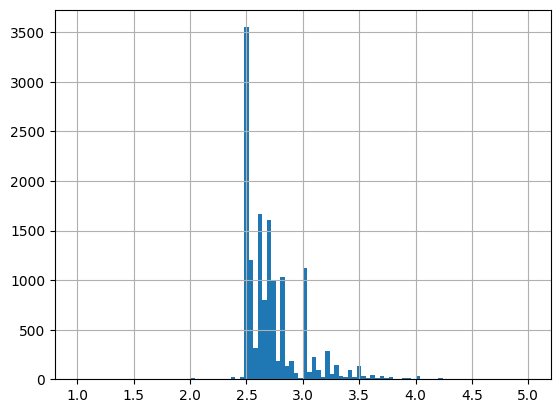

In [14]:
data['ceiling_height'].hist(bins = 100, range=(1,5));

Смотрим на распределение данных. В целом высота потолков в квартирах у нас отличается не сильно, есть явный пик на гистограмме. Заполним пустые значения столбца медианой.

In [15]:
data.loc[data['ceiling_height'].isna(),'ceiling_height'] = data['ceiling_height'].median()

Остается обработать floors_total - здесь невозможно использовать среднее/медиану. Причина пропусков в данных столбцах - продавец не ввёл данные. Учитывая малое количество пропусков в данном столбце - можем просто удалить строки.
Проверим результат заполнения пропусков данных.

In [16]:
#удаляем строки
data = data.dropna(subset=['floors_total'])
#выводим результат
print('Всего строк в датафрейме', len(data))
data.isna().sum()

Всего строк в датафрейме 23449


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5490
cityсenters_nearest      5467
parks_around_3000           0
parks_nearest           15453
ponds_around_3000           0
ponds_nearest           14455
days_exposition          3159
dtype: int64

**Вывод:** все столбцы обработаны. Пропущенные значения восстановлены, где это представлялось возможным.

#### Проверим типы данных в столбцах датафрейма data.

Сразу изменим тип данных в  first_day_exposition для удобства работы с датами. 

In [17]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Начнем с floors_total - по-своему интересный столбец, т.к. полутораэтажные дома в реальности существуют (в случае с ИЖС).\
Поэтому проверим список уникальных значений:

In [18]:
data['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., 20., 28.,
       36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

Случай не наш, поэтому меняем тип на int64:

In [19]:
data['floors_total'] = data['floors_total'].astype('int')

Аналогично в ponds_around_3000, parks_around_3000 - опять же целочисленный тип (сложно представить полтора парка).
Но чтобы наверняка, проверим и преобразуем:

In [20]:
print(data['ponds_around_3000'].unique())
print(data['parks_around_3000'].unique())

[2. 0. 3. 1.]
[1. 0. 2. 3.]


In [21]:
data['ponds_around_3000'] = data['ponds_around_3000'].astype('int')
data['parks_around_3000'] = data['parks_around_3000'].astype('int')

In [22]:
#аналогично с 'balcony'
data['balcony'] = data['balcony'].astype('int')
#можно привести также 'last_price'
data['last_price'] = data['last_price'].astype('int')

**Вывод:** все столбцы обработаны. Типы данных изменены, где это возможно и необходимо.

#### Устраним дубликаты

Дубликаты в нашем датафрейме могут возникнуть только в названиях населенных пунктов 'locality_name'. Выведем список уникальных значений.

In [23]:
print(data['locality_name'].unique(), '\n') #значения
print('Всего уникальных значений:', len(data['locality_name'].unique())) #количество значений


['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

Сразу видно, что используются два вида слова - "поселок" и "посёлок". Приведём к единому виду, используя 'е'.
Также встречаются "поселок" и "поселок городского типа" и "городской поселок". Обработаем аналогично, оставим "поселок". 

In [24]:
data['locality_name'] = data['locality_name'].str.replace('посёлок','поселок') #обрабатываем в 2 этапа, сначала уберем ё
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок')

print(data['locality_name'].unique(), '\n') #значения
print('Всего уникальных значений:', len(data['locality_name'].unique())) #количество

['Санкт-Петербург' 'поселок Шушары' 'поселок Янино-1' 'поселок Парголово'
 'поселок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин'
 'деревня Кудрово' 'Коммунар' 'Колпино' 'поселок Красный Бор' 'Гатчина'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'поселок Металлострой' 'поселок Лебяжье'
 'поселок Сиверский' 'поселок Молодцово' 'поселок Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'поселок Аннино' 'поселок Ефимовский'
 'поселок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'поселок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'поселок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'деревня Оржицы' 'деревня Кальтино'
 'Кудрово' 'поселок Романовка' 'поселок Бугры' 'поселок Рощино' 'Кириши'
 'Луга' 'Волосово'

Было - 364 значения, стало 322. 
Еще раз проверим явные дубликаты, на тот случай, если вдруг какой-либо пользователь подал объявление дважды, но по разному указал локацию.

In [25]:
data.duplicated().sum()

0

**Вывод:** Дубликаты устранены.

#### Проверим редкие и выбивающиеся значения.

Воспрользуемся describe() для оценки датафрейма

In [26]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
count,"23,449.0","23,449.0","23,449.0","23,449.0","23,449.0","23,449.0","23,449.0","23,449.0","23,449.0","23,449.0","17,959.0","17,982.0","23,449.0","7,996.0","23,449.0","8,994.0","20,290.0"
mean,9.881999232376646,"6,537,338.306836112",60.37502366838672,2.0730095100004267,2.722262356603693,10.664676532048276,34.53219796943346,5.870314299117233,10.468018805439463,0.5925199368843022,"28,805.34996380645","14,199.048048048047",0.4686340568894196,490.9811155577789,0.5895773806985373,518.1730042250389,180.94721537703302
std,5.680599649646391,"10,885,179.618468761",35.66579313166192,1.0770592481248698,0.966915049780966,6.586686580106139,22.30871651853386,4.864903947732076,5.992090309525104,0.9603964337720707,"12,631.406496901232","8,616.306380461552",0.747712887954411,341.2726951080655,0.8832884165492484,277.9894457887076,219.930138974313
min,0.0,"12,190.0",13.0,0.0,1.0,1.0,2.0,1.0,1.3,0.0,0.0,181.0,0.0,1.0,0.0,13.0,1.0
25%,6.0,"3,420,000.0",40.0,1.0,2.6,5.0,19.0,2.0,7.0,0.0,"18,574.5","9,238.0",0.0,288.0,0.0,293.0,45.00000000000001
50%,9.0,"4,650,000.0",52.0,2.0,2.65,9.0,30.0,4.0,9.0,0.0,"26,764.0","13,094.5",0.0,455.0,0.0,503.0,95.0
75%,14.0,"6,799,000.0",69.75,3.0,2.7,16.0,42.0,8.0,12.0,1.0,"37,274.0","16,293.0",1.0,612.0,1.0,730.0,232.0
max,50.0,"763,000,000.0",900.0,19.0,100.0,60.0,409.7,33.0,112.0,5.0,"84,869.0","65,968.0",3.0,"3,190.0",3.0,"1,344.0","1,580.0"


Отсортируем 'last_price', т.к. минимальная цена слишком маленькая.

In [27]:
data.sort_values(by='last_price').head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
8793,7,12190,109.0,2019-03-20,2,2.75,25,32.0,25,False,False,False,40.5,0,Санкт-Петербург,"36,421.0","9,176.0",1,805.0,0,NaN,8.0
14911,5,430000,54.0,2018-06-26,2,2.65,3,30.566037735849054,3,False,False,False,9.28125,0,поселок станции Свирь,NaN,NaN,0,NaN,0,NaN,44.00000000000001
17456,7,430000,30.4,2019-04-22,1,2.65,2,16.0,1,False,False,False,6.0,0,Сланцы,NaN,NaN,0,NaN,0,NaN,NaN
16274,18,440000,40.0,2018-07-10,1,2.65,5,22.641509433962263,1,False,False,False,6.875,0,деревня Старополье,NaN,NaN,0,NaN,0,NaN,45.00000000000001
9581,7,450000,43.4,2018-08-31,2,2.65,5,30.3,3,False,False,False,5.5,0,деревня Старополье,NaN,NaN,0,NaN,0,NaN,96.0
17676,0,450000,36.5,2018-02-01,1,2.65,5,17.3,4,False,False,False,8.5,1,деревня Ям-Тесово,NaN,NaN,0,NaN,0,NaN,120.0
5698,7,450000,42.0,2017-07-31,2,2.65,1,23.0,1,False,False,False,5.8,0,поселок Будогощь,NaN,NaN,0,NaN,0,NaN,233.0
16219,14,450000,38.5,2018-07-11,2,2.65,2,21.79245283018868,1,False,False,False,6.6171875,0,деревня Вахнова Кара,NaN,NaN,0,NaN,0,NaN,45.00000000000001
21912,0,470000,37.0,2018-02-18,1,2.65,3,20.943396226415093,3,False,False,False,6.359375,0,поселок Совхозный,NaN,NaN,0,NaN,0,NaN,45.00000000000001
23484,11,470000,44.5,2018-07-02,2,2.65,2,28.0,2,False,False,False,7.5,0,Сланцы,NaN,NaN,0,NaN,0,NaN,298.0


Есть одно выбивающееся значение. Скорее всего имеет место ошибка ввода. Удалим.

In [28]:
#отфильтруем датафрейм
data = data.query('last_price > 12190')

Обработаем 'total_area' - большое максимальное значение. Не будем исключать, что речь идет действительно о доме большой площади. Вернемся к гистограмме в начале исследования - большая часть продаваемых квартир укладывается в 250 кв.м. Рассмотрим подробней.

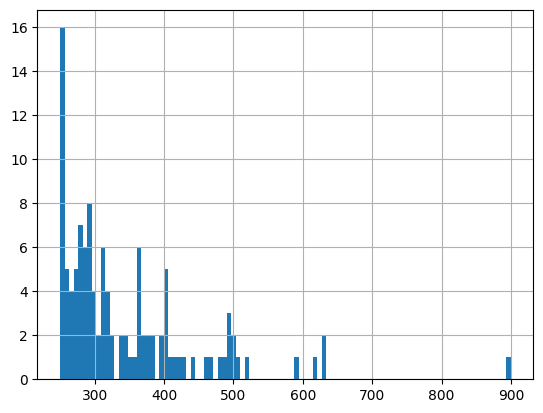

In [29]:
#укажем интересующий нас диапазон
data['total_area'].hist(bins = 100, range=(250,900));

In [30]:
#совсем мало квартир с общей площадью выше ~320. Изучим срез.
display(data.query('total_area > 320').sort_values(by='total_area'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
1085,16,75000000,323.0,2017-07-10,5,4.0,5,255.7,4,False,False,False,66.0,0,Санкт-Петербург,"23,713.0",594.0,3,398.0,2,515.0,259.0
14591,20,29000000,327.2,2017-11-15,6,2.65,4,177.3,4,False,False,False,27.1,0,Санкт-Петербург,"53,531.0","18,024.0",0,NaN,2,194.0,274.0
16179,11,28000000,336.0,2017-09-27,5,3.0,3,106.1,2,False,False,False,21.0,1,Санкт-Петербург,"15,036.0","14,795.0",2,668.0,0,NaN,172.0
2580,6,30900000,338.6,2017-10-16,7,3.86,6,230.0,4,False,False,False,20.0,0,Санкт-Петербург,"24,957.0","5,641.0",0,NaN,0,NaN,406.0
20820,7,73900000,342.0,2015-06-18,5,2.65,4,187.0,2,False,False,False,10.0,0,Санкт-Петербург,"25,079.0","5,544.0",0,NaN,1,251.0,377.00000000000006
19865,20,180000000,347.0,2015-01-21,8,3.9,6,260.0,3,False,False,False,45.0,0,Санкт-Петербург,"23,962.0","3,794.0",2,537.0,3,501.0,834.0
10569,13,36900000,347.5,2017-09-14,8,2.65,4,160.0,1,False,False,False,40.0,0,Колпино,"28,346.0","34,132.0",1,"1,809.0",2,241.0,249.0
15607,5,34000000,356.0,2017-09-12,7,3.55,7,248.5,5,False,False,False,18.9,0,Санкт-Петербург,"24,363.0","4,931.0",3,173.0,0,NaN,20.0
866,5,25000000,363.0,2017-12-23,14,3.16,5,222.0,4,False,False,False,16.6,0,Санкт-Петербург,"38,076.0","7,950.0",0,NaN,2,435.0,418.0
6183,10,84382000,363.1,2018-10-07,3,2.65,16,205.52830188679246,12,False,False,False,31.73,0,Санкт-Петербург,"31,887.0","4,979.0",0,NaN,2,182.0,NaN


При ознакомлении становится понятно, что данные не ошибочные, однако такие квартиры не просто элитная неджимость, скорее это очень индивидуальные варианты(фактически выбивающиеся значения), поэтому в анализе рассматривать их не будем.

In [31]:
#фильтруем датафрейм
data = data.query('total_area < 320')

Проанализируем столбец 'rooms'.

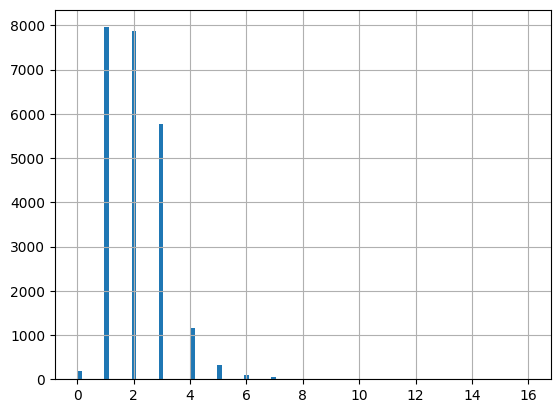

In [32]:
data['rooms'].hist(bins=100);

Присутствуют единичные значения больше 7 комнат, и есть значения равные нулю. Квартира без комнат? Возможно это студия или свободная планировка. 

In [33]:
#сначала рассмотрим квартиры в которых больше 8 комнат.
data.query('rooms > 8').sort_values(by = 'rooms')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
8860,12,17000000,235.0,2018-07-14,9,3.0,6,133.0188679245283,3,False,False,False,40.390625,0,Санкт-Петербург,"24,466.0","5,034.0",1,346.0,0,NaN,90.00000000000001
9550,10,23500000,313.0,2017-02-13,9,3.2,6,179.2,5,False,False,False,13.2,0,Санкт-Петербург,"38,435.0","10,138.0",1,146.0,0,NaN,NaN
13019,0,22250000,249.9,2019-04-23,9,3.2,5,157.0,5,False,False,False,12.4,0,Санкт-Петербург,"10,328.0","9,987.0",2,352.0,0,NaN,NaN
13397,14,19500000,309.7,2016-02-03,9,2.65,5,199.0,5,False,False,False,14.3,0,Санкт-Петербург,"10,328.0","9,987.0",2,352.0,0,NaN,468.0
16915,14,29000000,292.2,2017-01-12,9,3.35,5,225.9,4,False,False,False,32.9,1,Санкт-Петербург,"24,892.0","5,162.0",2,263.0,0,NaN,825.0
20791,0,24000000,250.0,2019-04-23,9,3.2,5,160.6,3,False,False,False,11.7,0,Санкт-Петербург,"10,328.0","9,987.0",2,352.0,0,NaN,NaN
4149,6,23000000,272.6,2018-01-11,10,3.14,7,145.9,7,False,False,False,18.8,1,Санкт-Петербург,"10,726.0","12,169.0",1,191.0,1,531.0,NaN
18119,4,15500000,216.1,2016-07-04,10,3.15,5,161.4,2,False,False,False,19.8,0,Санкт-Петербург,"24,353.0","4,921.0",1,368.0,0,NaN,11.000000000000002
18891,11,40000000,290.0,2016-06-21,10,3.5,6,189.4,6,False,False,False,30.0,1,Санкт-Петербург,"26,229.0","4,932.0",3,316.0,1,227.0,77.0
648,3,17500000,183.7,2018-07-01,11,3.4,7,138.8,7,False,False,False,13.3,0,Санкт-Петербург,"23,606.0","3,148.0",0,NaN,0,NaN,NaN


Есть несколько квартир, в которых больше 9 комнат, опять же индивидуальные предложения(выбивающиеся значения). В анализе использовать не будем.

In [34]:
#фильтруем датафрейм
data = data.query('rooms <= 9')

Рассмотрим столбец 'ceiling_height', а именно аномально высокие и низкие значения. Построим гистограммы в интересующих нас диапазонах.

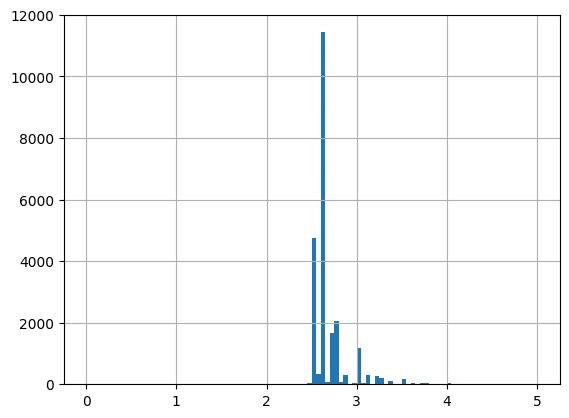

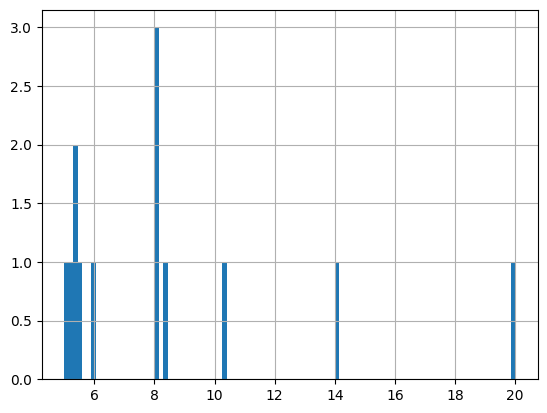

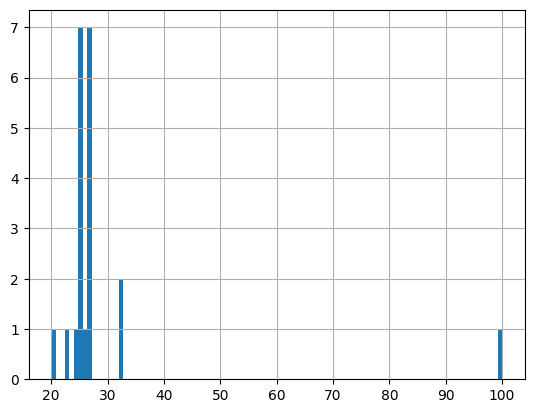

In [35]:
data['ceiling_height'].hist(bins=100, range=(0,5))
plt.show()
data['ceiling_height'].hist(bins=100, range=(5,20))
plt.show()
data['ceiling_height'].hist(bins=100, range=(20,100))
plt.show()

Есть диапазон значений от 20 до 35 метров, здесь скорее всего ошибка, и упущена запятая. Поправим.\
Квартира с высотой потолка 100 метров - явная ошибка. Удалим строку.
Квартиры с высотой потолков меньше 2.3 метра и больше 8 выглядят неправдоподобно и эти значения единичны. Отбросим

In [36]:
data.loc[(data['ceiling_height'] > 20) & (data['ceiling_height'] < 35), 'ceiling_height'] = data['ceiling_height'] / 10
data = data.query('ceiling_height < 8 and ceiling_height > 2.3')

Остается обработать значения в столбцах living_area и kitchen_area.

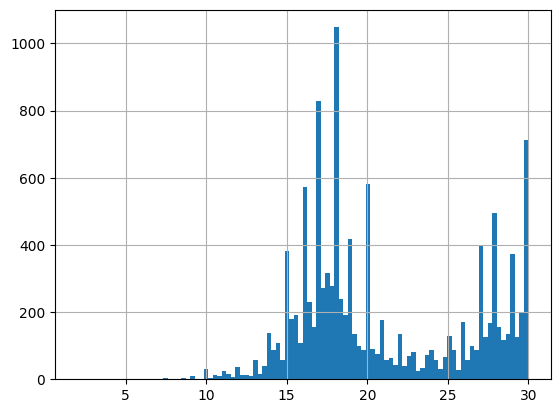

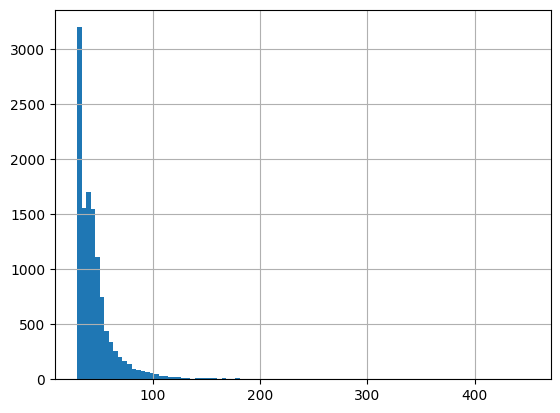

In [37]:
#изучим распределение living_area подробней
data['living_area'].hist(bins=100, range=(2,30))
plt.show()
data['living_area'].hist(bins=100, range=(30,450))
plt.show()

In [38]:
#изучим срез по минимальным значениям
data.query('living_area < 9').sort_values(by='living_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
21758,0,2330000,23.0,2018-01-01,0,2.65,24,2.0,22,False,True,False,3.953125,0,поселок Мурино,NaN,NaN,0,NaN,0,NaN,66.0
13915,20,6350000,52.0,2018-02-06,2,3.0,6,2.0,2,False,False,False,9.0,0,Санкт-Петербург,"32,453.0","6,521.0",0,NaN,1,"1,012.0",91.0
23574,14,64990000,139.0,2015-11-24,3,3.0,8,3.0,8,False,False,False,16.0,1,Санкт-Петербург,"33,255.0","5,975.0",1,630.0,3,100.0,280.0
3242,7,4440000,41.0,2017-07-02,1,2.65,17,3.0,17,False,False,False,11.0,0,Санкт-Петербург,"19,272.0","13,073.0",0,NaN,0,NaN,216.0
17582,11,2680000,22.0,2018-08-11,0,2.65,25,5.0,8,False,True,False,3.78125,2,Санкт-Петербург,"22,735.0","11,618.0",1,835.0,1,652.0,70.0
21943,15,6100000,77.6,2019-02-28,4,2.5,9,5.4,1,False,False,False,9.8,0,Санкт-Петербург,"29,338.0","11,270.0",1,584.0,0,NaN,33.0
16431,13,3799000,31.0,2018-04-12,1,2.6,5,6.0,1,False,False,False,17.0,0,Санкт-Петербург,"32,177.0","4,826.0",1,430.0,0,NaN,168.0
19251,19,4050000,33.0,2018-10-15,1,2.5,22,6.5,21,False,False,False,18.0,0,Санкт-Петербург,"9,258.0","10,592.0",1,458.0,0,NaN,44.00000000000001
19546,3,1850000,13.0,2019-03-11,1,3.4,5,7.3584905660377355,2,False,False,False,2.234375,0,Санкт-Петербург,"24,915.0","5,483.0",1,644.0,0,NaN,24.000000000000004
17961,3,1400000,13.0,2017-12-03,1,2.6,9,7.3584905660377355,1,False,False,False,2.234375,0,Санкт-Петербург,"14,350.0","15,945.0",0,NaN,1,185.0,410.0


Видим единичные значения в 'living_area' менее 9 кв.м., которые выглядят странно. Их мы использовать не будем.
Можно также отбросить единичные значения больше ~135. Ознакомимся со срезом.

In [39]:
data.query('living_area > 135').sort_values(by='living_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
18713,20,23000000,240.0,2015-01-21,4,3.69,6,135.8490566037736,4,False,False,False,15.0,1,Санкт-Петербург,"22,633.0","4,353.0",1,303.0,0,NaN,NaN
9479,6,19000000,201.0,2015-06-24,6,2.65,6,136.0,2,False,False,False,20.0,0,Санкт-Петербург,"26,995.0","5,698.0",3,304.0,1,133.0,925.0
9889,1,12990000,191.0,2017-08-31,7,3.3,5,136.1,2,False,False,False,16.0,0,Санкт-Петербург,"26,856.0","5,704.0",0,NaN,1,"1,017.0",77.0
12248,20,43000000,237.8,2017-03-03,5,2.65,10,136.2,4,False,False,False,30.0,0,Санкт-Петербург,"25,108.0","3,956.0",1,530.0,3,756.0,NaN
12674,16,140000000,241.0,2015-07-24,5,3.0,5,136.41509433962264,4,False,False,False,41.421875,0,Санкт-Петербург,"23,512.0","3,503.0",3,413.0,3,83.0,399.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10246,10,25023000,253.7,2017-11-10,6,2.65,4,200.0,2,False,False,False,33.0,0,Санкт-Петербург,"20,687.0","1,214.0",3,103.0,3,155.0,90.00000000000001
21685,7,22160000,277.6,2017-08-19,7,3.8,6,211.0,3,False,False,False,17.8,0,Санкт-Петербург,"25,761.0","5,671.0",2,375.0,1,479.0,22.000000000000004
16915,14,29000000,292.2,2017-01-12,9,3.35,5,225.9,4,False,False,False,32.9,1,Санкт-Петербург,"24,892.0","5,162.0",2,263.0,0,NaN,825.0
793,20,135000000,310.0,2018-05-22,4,3.3,5,250.0,2,False,False,False,50.0,0,Санкт-Петербург,"34,159.0","7,251.0",2,295.0,3,190.0,342.0


In [40]:
#фильтруем
data = data.query('9 <= living_area < 135')

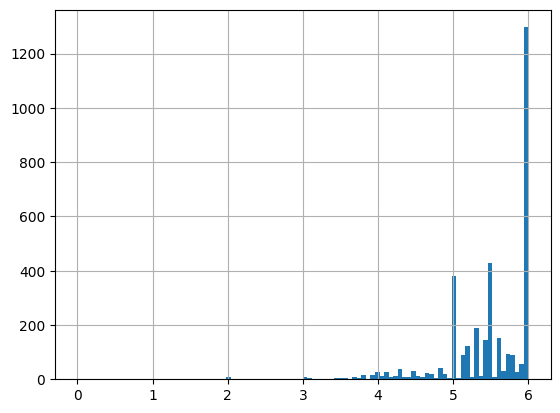

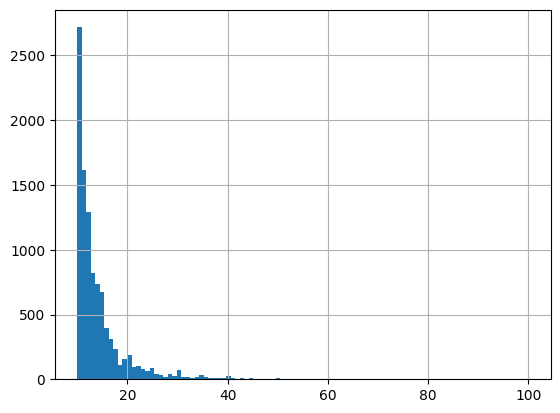

In [41]:
#изучим распределение kitchen_area подробней
data['kitchen_area'].hist(bins=100, range=(0,6))
plt.show()
data['kitchen_area'].hist(bins=100, range=(10,100))
plt.show()

In [42]:
#сделаем срез по максимальным значениям
data.query('kitchen_area > 40').sort_values(by='kitchen_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
23327,19,34400000,215.0,2019-03-15,5,2.75,4,82.4,4,False,False,False,40.1,0,Санкт-Петербург,"37,268.0","15,419.0",0,NaN,0,NaN,NaN
18501,20,9950000,92.5,2018-07-23,2,2.65,4,38.0,2,False,False,False,40.2,0,Санкт-Петербург,"19,956.0","3,327.0",1,312.0,1,235.0,NaN
15857,6,25000000,145.2,2014-11-27,3,2.65,5,60.7,5,False,False,False,40.2,0,Санкт-Петербург,"36,779.0","14,931.0",0,NaN,0,NaN,NaN
2731,0,25000000,148.3,2018-04-04,3,2.65,5,83.9433962264151,5,False,False,False,40.2,0,Санкт-Петербург,"36,334.0","14,486.0",0,NaN,0,NaN,NaN
2127,14,32500000,234.0,2016-05-26,5,2.65,7,132.45283018867923,6,False,False,False,40.21875,0,Санкт-Петербург,"23,987.0","4,554.0",1,320.0,0,NaN,180.00000000000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4394,20,57000000,174.0,2015-11-09,3,3.2,10,95.0,6,False,False,False,77.0,0,Санкт-Петербург,"31,706.0","4,166.0",1,193.0,3,199.0,"1,039.0"
10867,1,56844500,177.9,2015-01-15,3,2.65,6,87.2,5,True,False,False,87.2,0,Санкт-Петербург,"21,860.0",318.0,2,160.0,3,569.0,NaN
16797,9,65850000,146.0,2017-07-14,2,2.65,9,40.0,3,False,False,False,93.0,0,Санкт-Петербург,"25,525.0","5,845.0",2,116.0,0,NaN,77.0
16239,5,82400000,181.1,2017-05-24,3,3.9,9,58.2,4,False,False,False,93.2,0,Санкт-Петербург,"25,525.0","5,845.0",2,116.0,0,NaN,501.0


После 40 кв.м. в столбце 'kitchen_area' мало значений. Отбросим как выбивающиеся.

In [43]:
#фильтруем
data = data.query('kitchen_area < 40')
#сделаем срез по минимальным значениям
data.query('kitchen_area < 5').sort_values(by='kitchen_area').head(50)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
20217,7,4250000,28.5,2019-05-01,1,2.8,14,19.5,10,False,False,False,1.3,0,Санкт-Петербург,"37,199.0","12,721.0",0,NaN,0,NaN,NaN
9138,17,2920000,23.29,2018-12-12,1,2.65,3,21.0,1,False,False,False,2.0,0,Санкт-Петербург,"19,506.0","4,008.0",0,NaN,2,45.0,107.0
16367,2,2720000,25.7,2017-10-30,1,2.65,19,22.6,11,False,False,False,2.0,0,Санкт-Петербург,"14,472.0","13,268.0",0,NaN,0,NaN,109.0
6262,9,3100000,24.0,2018-06-25,2,3.0,5,16.0,5,False,False,False,2.0,0,Санкт-Петербург,"31,960.0","4,914.0",2,426.0,1,936.0,54.0
19642,5,1190000,14.0,2018-07-29,1,2.65,5,11.0,1,False,False,False,2.0,0,Санкт-Петербург,"9,898.0","11,122.0",0,NaN,0,NaN,4.0
11033,6,5350000,32.0,2016-04-20,1,2.65,14,16.0,10,False,False,False,2.0,0,Санкт-Петербург,"19,008.0","3,953.0",0,NaN,1,69.0,210.0
21419,4,1870000,20.0,2018-03-06,1,2.5,5,14.0,1,False,False,False,2.0,0,Санкт-Петербург,"16,652.0","15,654.0",1,619.0,1,937.0,45.00000000000001
906,15,2600000,27.0,2017-07-10,1,2.75,23,18.0,18,False,False,False,2.0,0,Санкт-Петербург,"22,131.0","17,459.0",0,NaN,1,411.0,10.0
19807,0,3800000,13.0,2018-07-04,1,2.65,5,10.0,3,False,False,False,2.234375,0,Санкт-Петербург,"21,302.0","1,242.0",1,592.0,3,27.0,9.0
17834,5,2940000,34.7,2017-10-09,1,2.65,26,15.5,14,False,False,False,2.3,1,поселок Мурино,NaN,NaN,0,NaN,0,NaN,318.0


С минимальными значениями ситуация куда интересней. Просто ознакомившись с 10 строками можно уже сделать вывод, что судя по всему, есть совсем маленькие кухни, но их мало. Смотрим на гистограмму и в принципе можно отбросить значения меньше 5.

In [44]:
data = data.query('kitchen_area >= 5')

In [45]:
#сбросим индексы после предобработки датафрейма
data = data.reset_index(drop=True)

#проверим размер датафрейма, изначально было 23699 строк
print('Потеряно данных в результате предобработки:', 100-len(data)/23699*100, '%')

Потеряно данных в результате предобработки: 4.31663783281995 %


**Вывод:** Предварительная обработка датафрейма завершена. Потеряно 4.3% данных.\
Большая часть проблем в данных - человеческие ошибки при заполнении объявлений о продаже. Распределение данных соответствует ожиданиям и зависит от объективных факторов (площадь, местоположение). Из анализа были исключены квартиры нетипичными/индивидуальными параметрами, т.к. фактически они являются выбивающимися значениями. Изменения в датафрейм внесены минимально, т.к. на рынке недвижимости достаточно много индивидуальных особенностей квартир, что не является ошибкой в данных.

### Дополнительные столбцы.

**Добавим в таблицу столбцы:**\
цена одного квадратного метра

In [46]:
data['meter_price'] = round(data['last_price']/data['total_area'], 2) #сразу округлим до 2 знаков

день недели публикации объявления

In [47]:
data['weekday'] = data['first_day_exposition'].dt.weekday + 1

месяц публикации объявления

In [48]:
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

год публикации объявления

In [49]:
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

тип этажа квартиры (категории "первый", "последний", "другой")

In [50]:
#напишем функцию, которая получит строку, а вернет тип этажа
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

#применим ко всем строкам датафрейма и создадим требуемый столбец
data['floor_type'] = data.apply(floor_type, axis=1)

расстояние до центра города в километрах

In [51]:
data['cityсenters_nearest_km'] = round(data['cityсenters_nearest'] / 1000)

In [52]:
#проверим
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityсenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,meter_price,weekday,month,year,floor_type,cityсenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.7,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,"18,863.0","16,028.0",1,482.0,2,755.0,NaN,"120,370.37",4,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,поселок Шушары,"12,817.0","18,603.0",0,NaN,0,NaN,81.0,"82,920.79",2,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,"21,741.0","13,933.0",1,90.0,2,574.0,558.0,"92,785.71",4,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,90.0,9,False,False,False,27.328125,0,Санкт-Петербург,"28,098.0","6,800.0",2,84.0,3,234.0,424.0,"408,176.1",5,7,2015,другой,7.0
4,10,2890000,30.4,2018-09-10,1,2.65,12,14.4,5,False,False,False,9.1,0,поселок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0,"95,065.79",1,9,2018,другой,NaN


**Вывод:** столбцы успешно добавлены.

### Исследовательский анализ данных

#### Изучим параметры объектов.


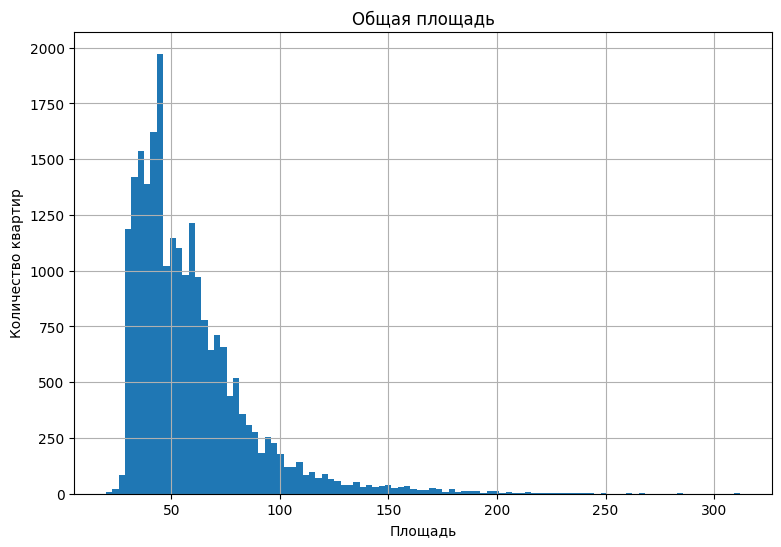

In [53]:
plt.title('Общая площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
data['total_area'].hist(figsize=(9, 6), bins=100);

**Вывод:** Большая часть продаваемых квартир имеет площадь 25-70 кв.м. Далее чем больше площадь - тем меньше квартир на продаже.

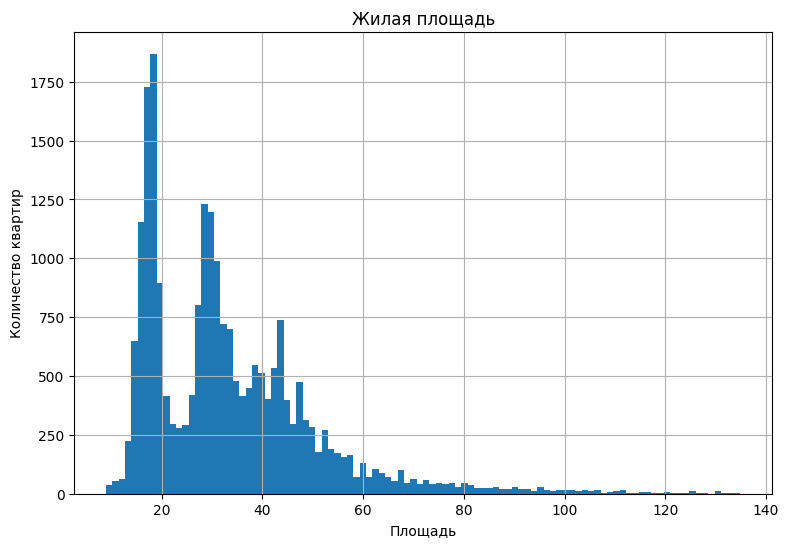

In [54]:
plt.title('Жилая площадь')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
data['living_area'].hist(figsize=(9, 6), bins=100);

**Вывод:** Жилая площадь квартир распределена неравномерно. 

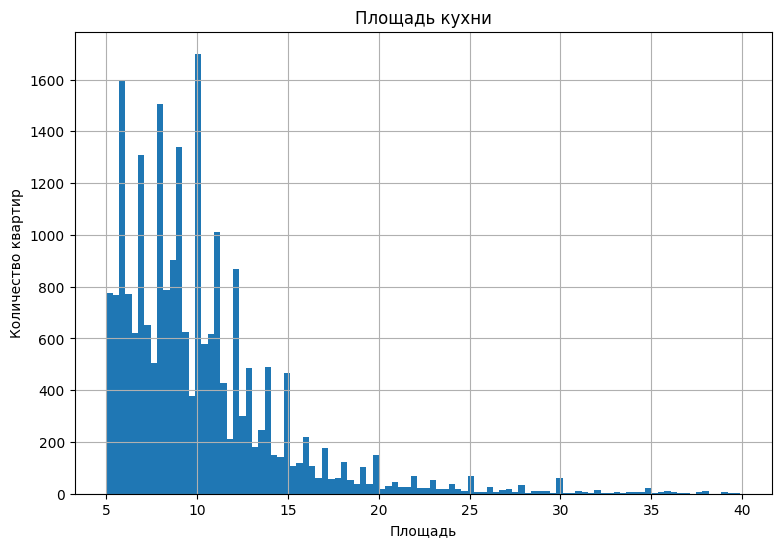

In [55]:
plt.title('Площадь кухни')
plt.xlabel('Площадь')
plt.ylabel('Количество квартир')
data['kitchen_area'].hist(figsize=(9, 6), bins=100);

**Вывод:** Площадь кухни квартир также распределена неравномерно. Имеются значения близкие к нулю, это может быть связано с квартирами студиями/свободной планировкой, а также с ошибками при внесении данных пользователями.\
В конечном счете параметры площади, как жилой, так и общей и площади кухни - зависят от параметров жилого фонда, отсюда их неравномерное распределение.

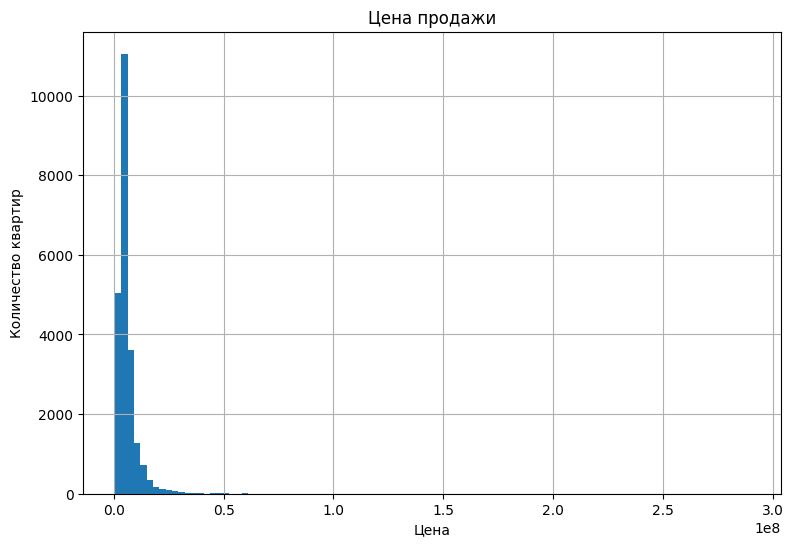

In [56]:
plt.title('Цена продажи')
plt.xlabel('Цена')
plt.ylabel('Количество квартир')
data['last_price'].hist(figsize=(9, 6), bins=100);

4650000.0

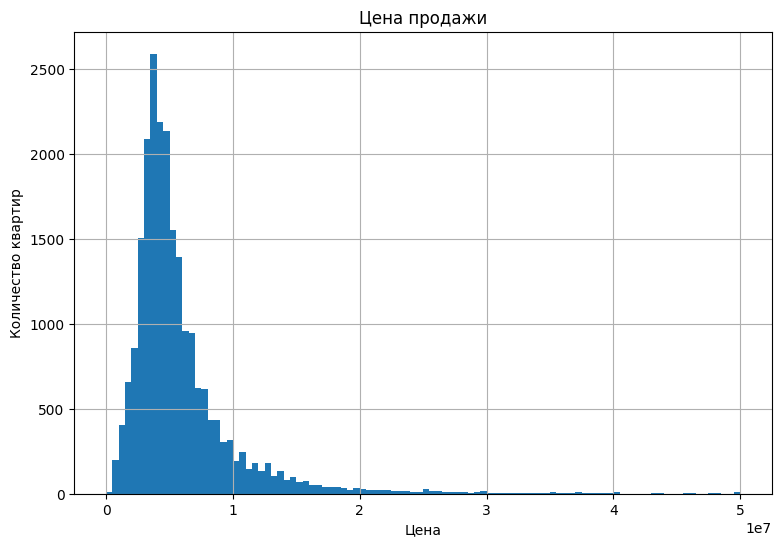

In [84]:
#Установим другие параметры гистограммы для более подробного анализа
plt.title('Цена продажи')
plt.xlabel('Цена')
plt.ylabel('Количество квартир')
data['last_price'].hist(figsize=(9, 6), bins=100, range=(0,50000000))
data['last_price'].median() # дополнительно для удобства воспрития

**Вывод:** Большая часть квартир стоит в среднем в диапазоне от 1 до 10 млн. Есть варианты и дешевле, и дороже, но в целом распределение нормальное. Самая популярная цена - около 4 млн.

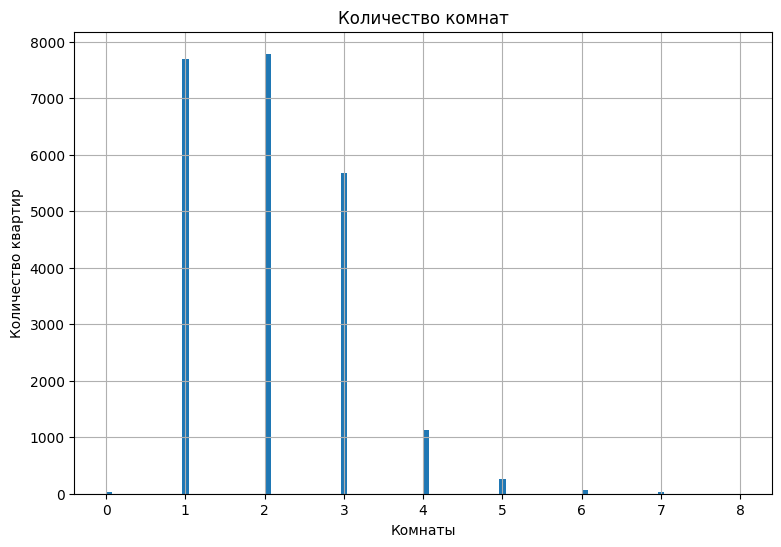

In [58]:
plt.title('Количество комнат')
plt.xlabel('Комнаты')
plt.ylabel('Количество квартир')
data['rooms'].hist(figsize=(9, 6), bins=100);

**Вывод:** Большая часть квартир - 1,2 и 3х комнатные. Менее популярны 4х комнатные, а за ними уже 5, студии и квартиры с числом комнат более 6

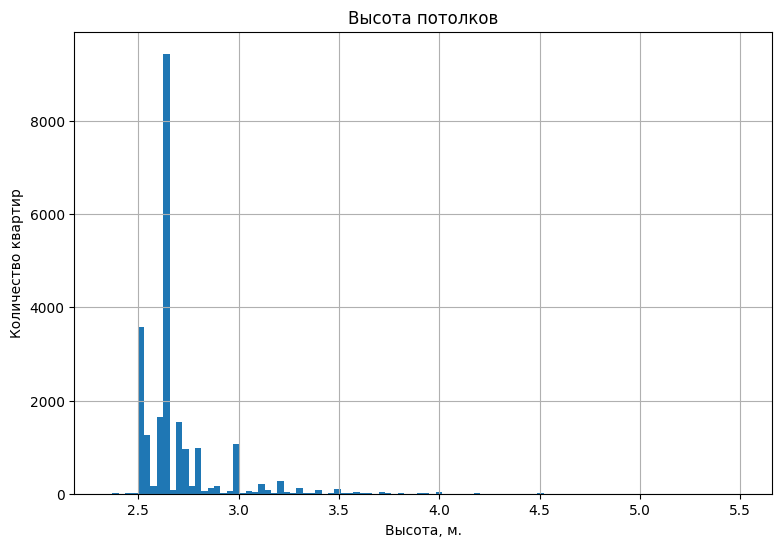

In [59]:
plt.title('Высота потолков')
plt.xlabel('Высота, м.')
plt.ylabel('Количество квартир')
data['ceiling_height'].hist(figsize=(9, 6), bins=100);

**Вывод:** Типовая высота потолков в квартирах - 2.7 метра, есть варианты с небольшим отклонением в меньшую и в большую сторону. Квартир с высокими потолками (выше 3 метров) в сравнении с другими совсем мало, как и квартир с потолками ниже 2.5 метров.

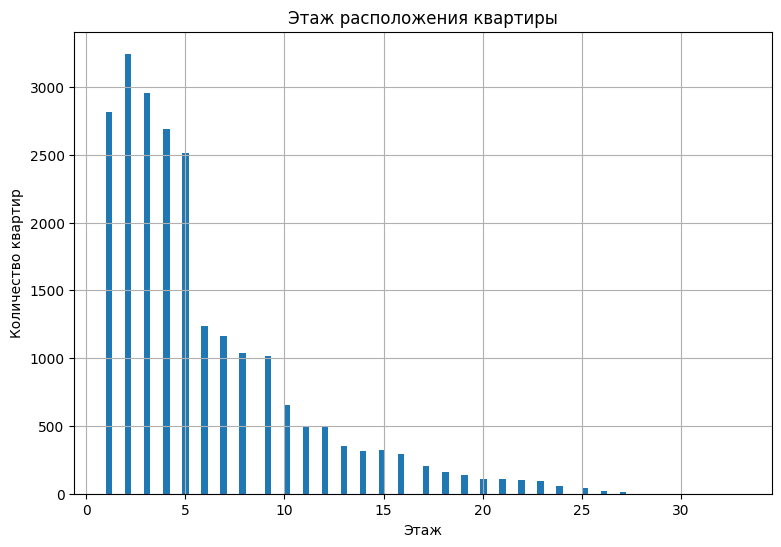

In [60]:
plt.title('Этаж расположения квартиры')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
data['floor'].hist(figsize=(9, 6), bins=100);

**Вывод:** Самые продаваемые квартиры в диапазоне от 1 до 5 этажа включительно.

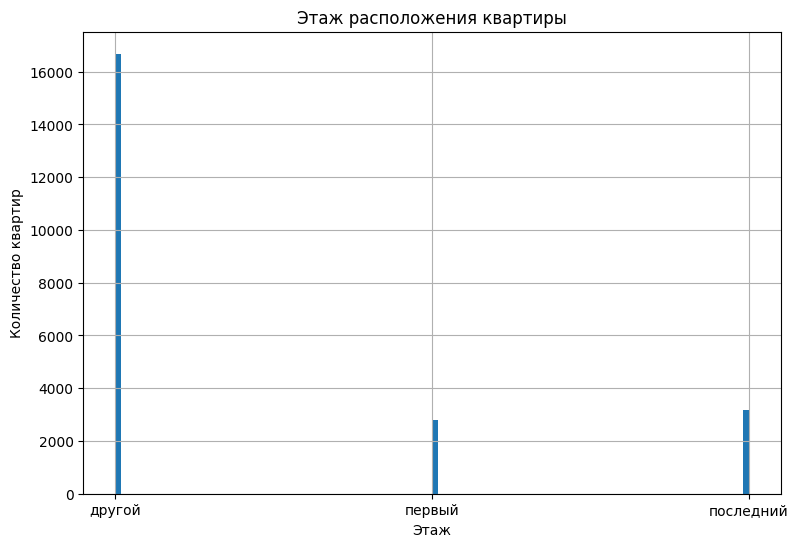

In [61]:
plt.title('Этаж расположения квартиры')
plt.xlabel('Этаж')
plt.ylabel('Количество квартир')
data['floor_type'].hist(figsize=(9, 6), bins=100);

**Вывод:** В дополнение к предыдущей гистограмме - квартиры на первом и последнем этаже продаются достаточно часто (в сравнении с другими). Отношение примерно 1/3.

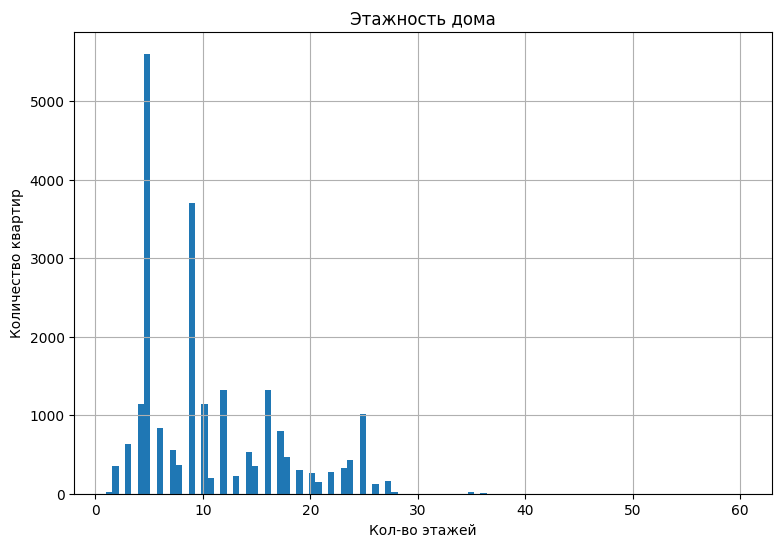

In [62]:
plt.title('Этажность дома')
plt.xlabel('Кол-во этажей')
plt.ylabel('Количество квартир')
data['floors_total'].hist(figsize=(9, 6), bins=100);

**Вывод:** Самые распространённые дома в СПБ и области - 5,9,12,16 этажные. А вот "небоскребов" и одноэтажных практически нет.

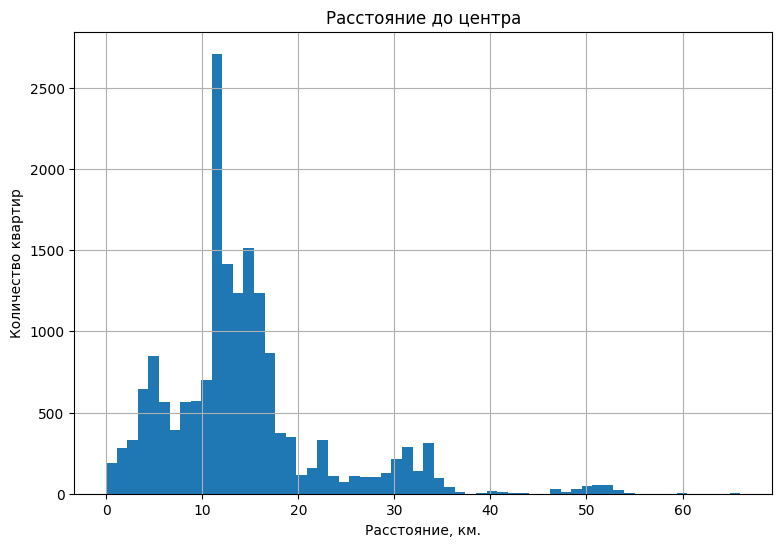

In [63]:
plt.title('Расстояние до центра')
plt.xlabel('Расстояние, км.')
plt.ylabel('Количество квартир')
data['cityсenters_nearest_km'].hist(figsize=(9, 6), bins=60);

**Вывод:** Большая часть продаваемых квартир расположена на некотором отдалении от центра (10-17 км). В центре тоже есть продажи, но их на порядок меньше. На окраинах города квартир продается еще меньше, как и в области. Очевидно, количество продаваемых квартир зависит от плотности застройки.

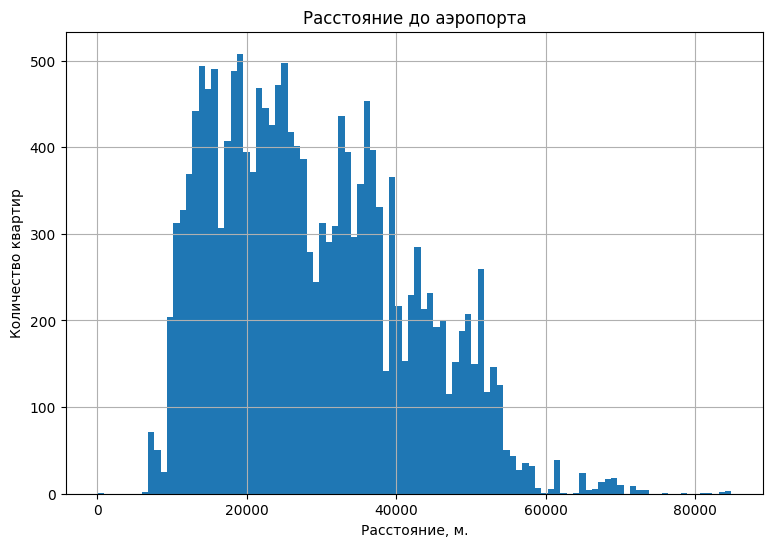

In [64]:
plt.title('Расстояние до аэропорта')
plt.xlabel('Расстояние, м.')
plt.ylabel('Количество квартир')
data['airports_nearest'].hist(figsize=(9, 6), bins=100);

**Вывод:** Непосредственно возле аэропорта нет жилых домов.

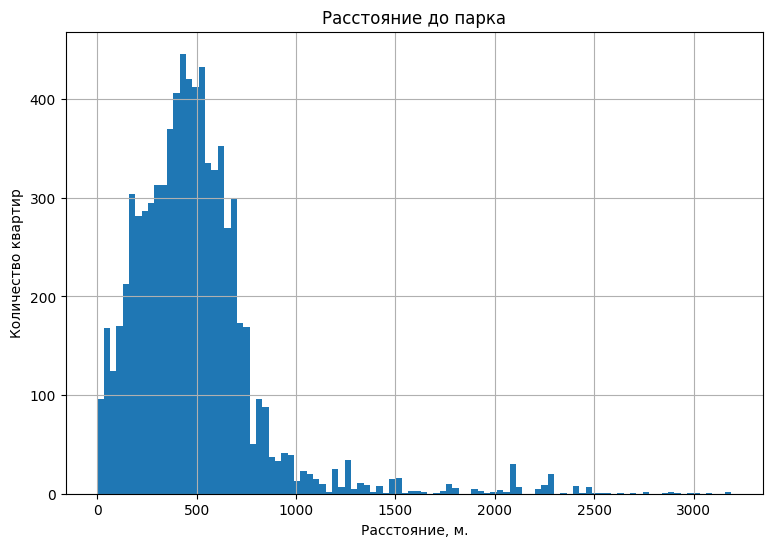

In [65]:
plt.title('Расстояние до парка')
plt.xlabel('Расстояние, м.')
plt.ylabel('Количество квартир')
data['parks_nearest'].hist(figsize=(9, 6), bins=100);

**Вывод:** Если рядом с квартирой имеется парк, то ближайший из них находится на расстоянии 1000 метров или меньше.

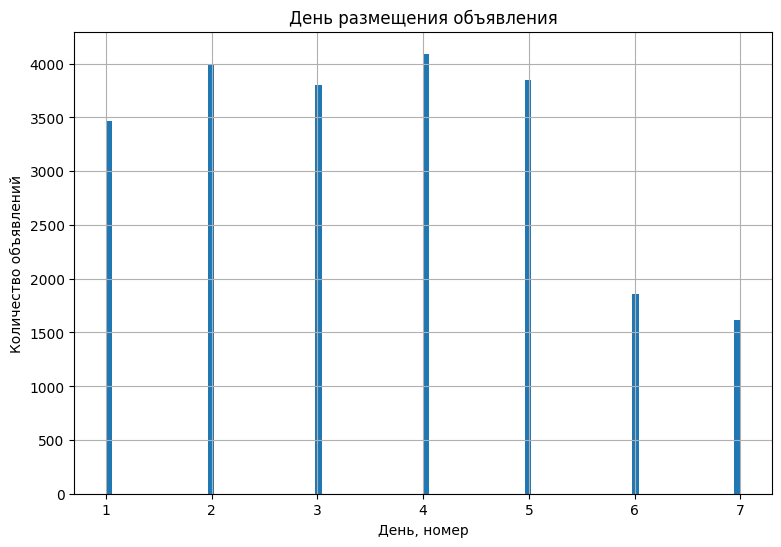

In [66]:
plt.title('День размещения объявления')
plt.xlabel('День, номер')
plt.ylabel('Количество объявлений')
data['weekday'].hist(figsize=(9, 6), bins=100);

**Вывод:** В выходные дни объявления выставляют почти в 2 раза реже, чем в другие.

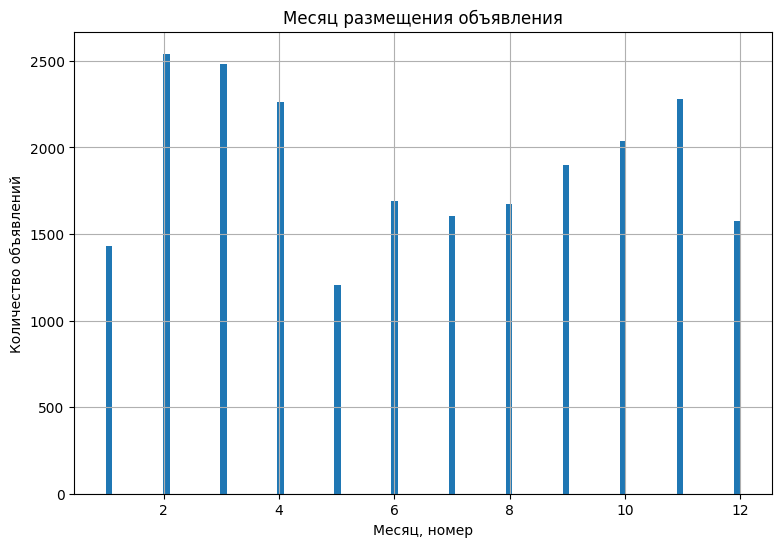

In [67]:
plt.title('Месяц размещения объявления')
plt.xlabel('Месяц, номер')
plt.ylabel('Количество объявлений')
data['month'].hist(figsize=(9, 6), bins=100);

**Вывод:** Пик продаж наблюдается весной и осенью. Основной же спад происходит в новый год и в ожидании летнего сезона.

После предобработки данных выполнен анализ по каждому из требуемых параметров с использованием гистограмм. По каждой гистограмме дан подробный комментарий.

#### Проанализируем, как быстро продавались квартиры.

Среднее значение дней размещения объявления: 180.6
Медианное значение дней размещения объявления: 96.0


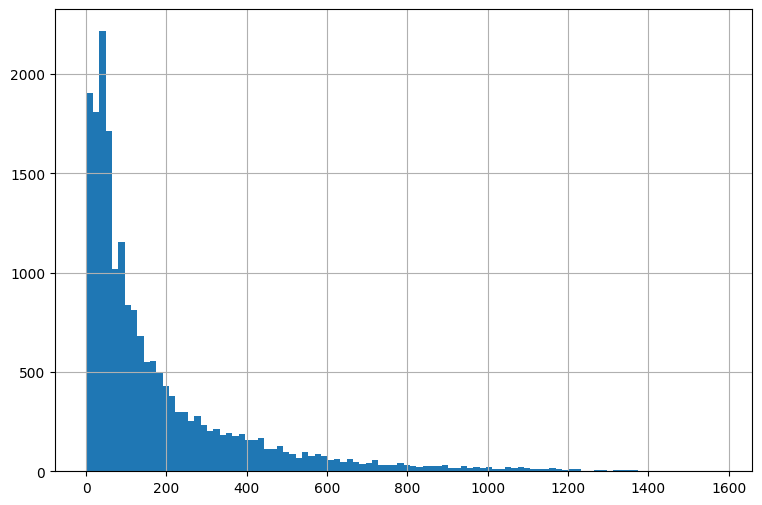

In [68]:
#построим гистограмму используя данные о том, сколько было размещено объявление. Найдём среднее и медиану.
data['days_exposition'].hist(figsize=(9, 6), bins=100);
print('Среднее значение дней размещения объявления:', round(data['days_exposition'].mean(), 1))
print('Медианное значение дней размещения объявления:', data['days_exposition'].median())

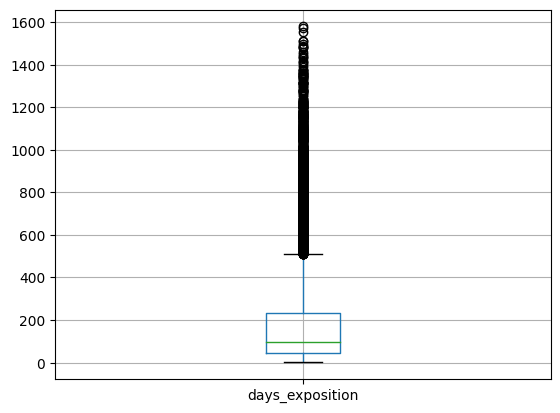

In [69]:
data['days_exposition'].plot.box(grid=True);

In [70]:
data['days_exposition'].describe()

count             19,639.0
mean    180.61362594836805
std      218.9505362292769
min                    1.0
25%      45.00000000000001
50%                   96.0
75%                  231.0
max                1,580.0
Name: days_exposition, dtype: float64

Средний срок продажи квартиры составляет 180 дней(с учетом аномально долгих продаж).
При этом половина квартир продается к 96 дню, 75% продаются быстрее 231 дней, а 25% быстрее 45 дней.

Быстрыми можно считать продажи в срок 1 - 45 дней, долгими - 231 - 450 дней, а необычно долгими - примерно от 450 дней.
Значение стандартного отклонения говорит о том, что сроки продаж весьма неравномерны.

#### От каких факторов зависит полная стоимость объекта?
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);

In [71]:
# полная стоимость объекта содержится в столбце last_price
# выводы будем делать по столбцам total_area, living_area, kitchen_area, rooms, floor_type, weekday, year, month

##### Проанализируем зависимость цены от общей площади.

Корреляция: 0.6917434095311474


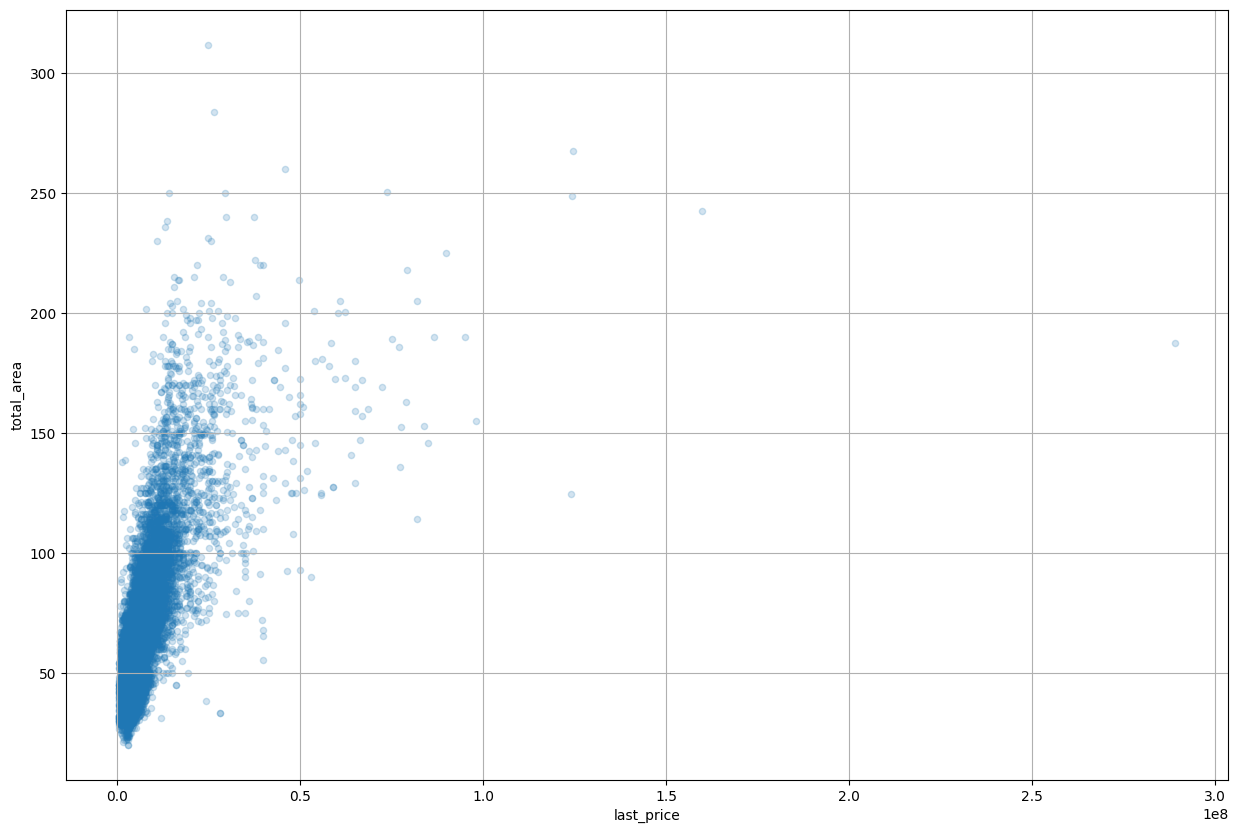

In [72]:
#total_area, строим диаграмму рассеяния на основе требуемых столбцов
(
    data.loc[:,['total_area','last_price']]
    .sort_values(by='total_area')
    .plot(x='last_price', y='total_area', kind='scatter', figsize=(15, 10), grid=True, alpha=0.2)
)
#рассчитаем корреляцию
print('Корреляция:', data['total_area'].corr(data['last_price']))

**Вывод:** 
Прослеживается явная зависимость цены квартиры от её общей площади. Об этом говорит как коэффициент корреляции 0.69, так и диаграмма рассеяния. Также по диаграмме видно, что у квартир с площадью свыше 100 зависимость цены и площади падает. 
Есть также некоторое количество квартир, у которых цена и площадь коррелируют значительно меньше - вероятнее всего это "элитная" недвижимость.

##### Проанализируем зависимость цены от жилой площади.

Корреляция: 0.5992095025294171


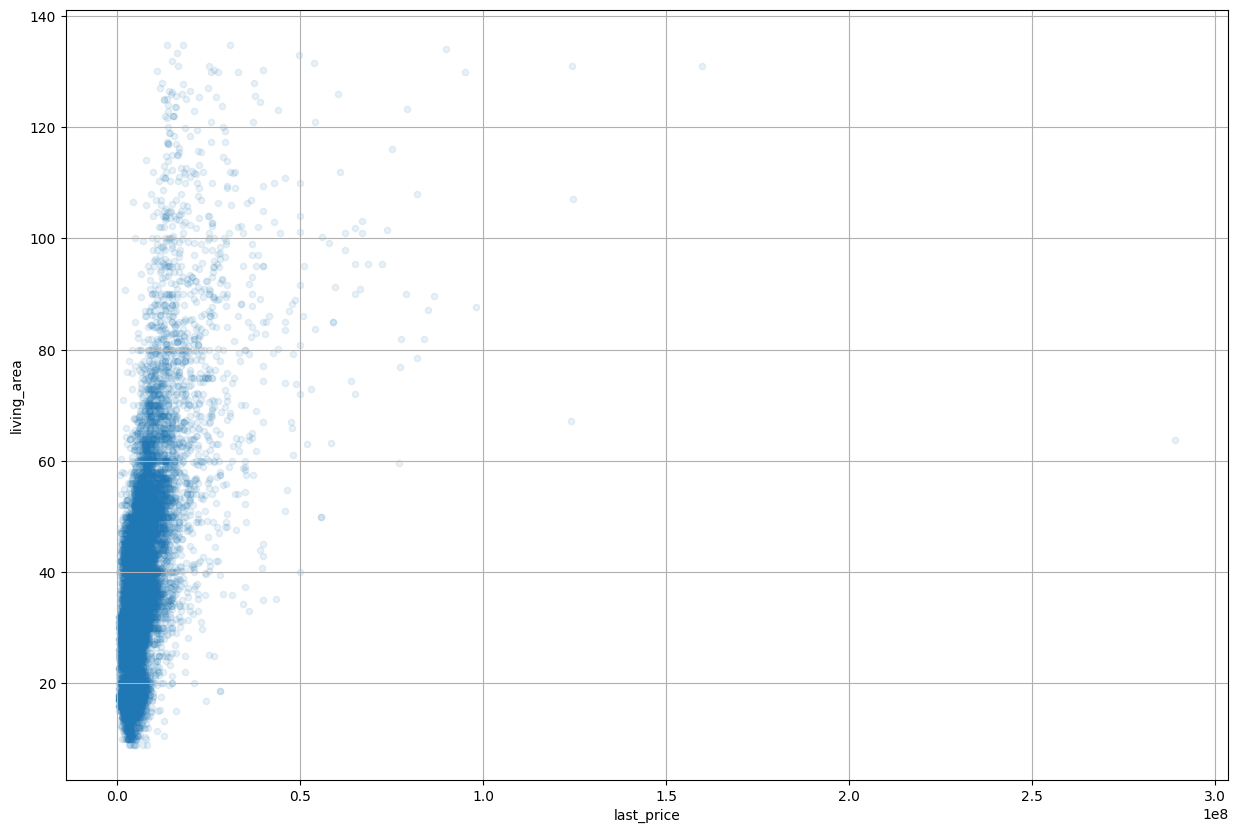

In [73]:
#living_area, строим диаграмму рассеяния на основе требуемых столбцов
(
    data.loc[:,['living_area','last_price']]
    .sort_values(by='living_area')
    .plot(x='last_price', y='living_area', kind='scatter', figsize=(15, 10), grid=True, alpha=0.1)
)
#рассчитаем корреляцию
print('Корреляция:', data['living_area'].corr(data['last_price']))

**Вывод:** 
Зависимость цены от жилой площади квартиры уже несколько меньше, чем от общей. Коэффициент корреляции 0.6. Чем больше площадь квартиры - тем больше разброс цен.

##### Проанализируем зависимость цены от площади кухни.

Корреляция: 0.5183163367088902


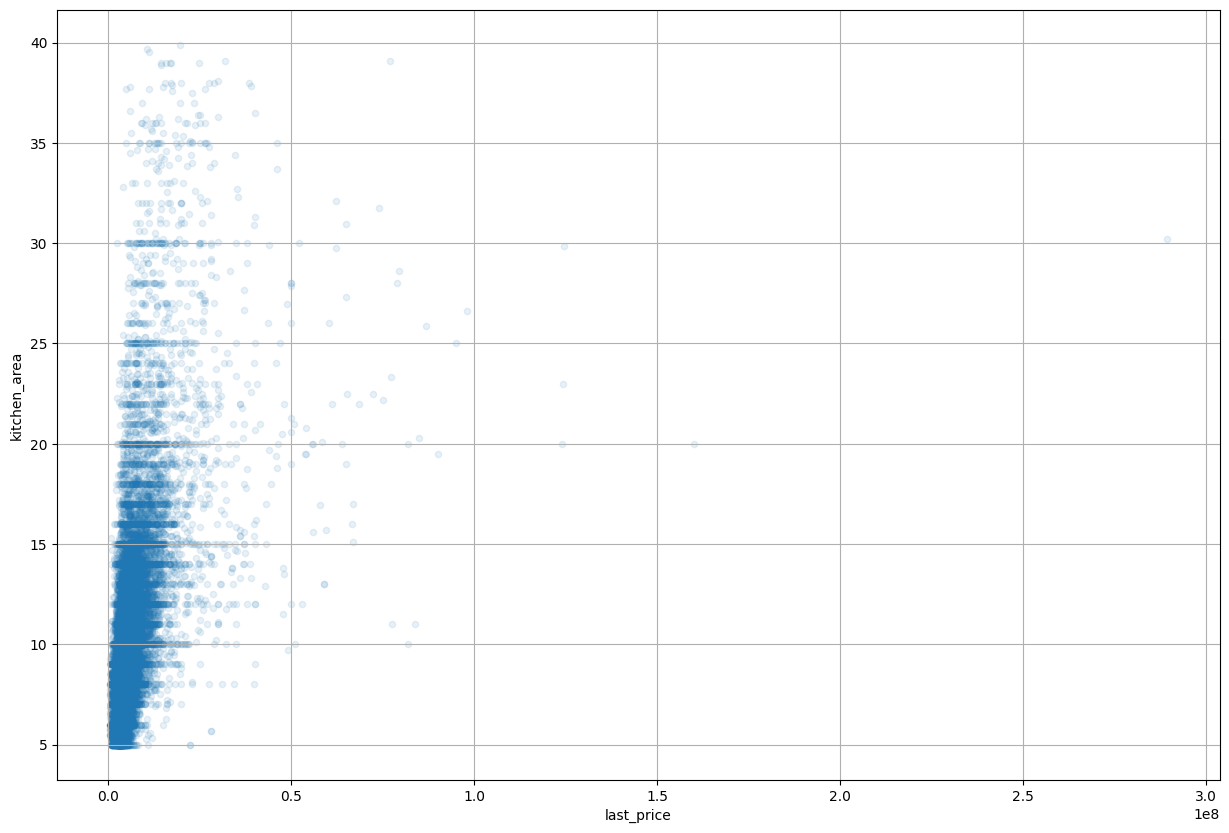

In [74]:
#living_area, строим диаграмму рассеяния на основе требуемых столбцов
(
    data.loc[:,['kitchen_area','last_price']]
    .sort_values(by='kitchen_area')
    .plot(x='last_price', y='kitchen_area', kind='scatter', figsize=(15, 10), grid=True, alpha=0.1)
)
#рассчитаем корреляцию
print('Корреляция:', data['kitchen_area'].corr(data['last_price']))

**Вывод:** Зависимость цены от площади кухни квартиры еще меньше, чем от общей. Коэффициент корреляции 0.5. Величины уже достаточно слабо коррелируют, а также у квартир с любым размером кухни есть ощутимый разброс в цене.

#####  **Проанализируем зависимость цены от количества комнат, типа этажа и даты размещения.**
Начнём с количества комнат.
Вычислим среднюю цену в зависимости от количества комнат.

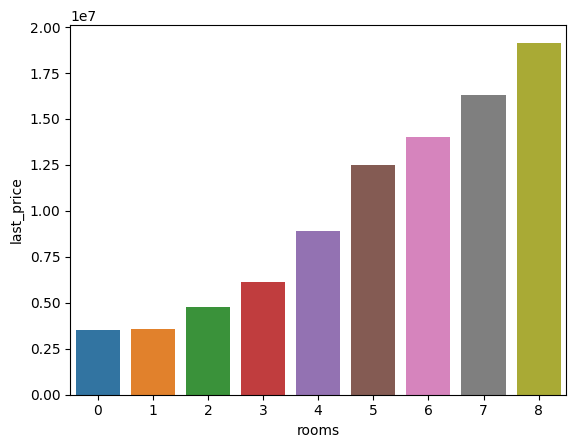

In [75]:
temp = data.pivot_table(index='rooms', values='last_price', aggfunc='median')
temp['rooms'] = temp.index.get_level_values(0)
seaborn.barplot(data=temp, y='last_price', x='rooms');

**Вывод:**\
Стоимость квартир равномерно возрастает до 7 комнат. При большем количестве комнат она практически не меняется, однако вывод более чем по 7 комнатам необъективен, т.к. выборка нерепрезентативна (мало данных).


In [76]:
#Код ревьюера 

data.rooms.value_counts()

2    7784
1    7698
3    5680
4    1128
5     265
6      61
0      36
7      22
8       2
Name: rooms, dtype: int64

##### Исследуем зависимость цены квартиры от этажа.

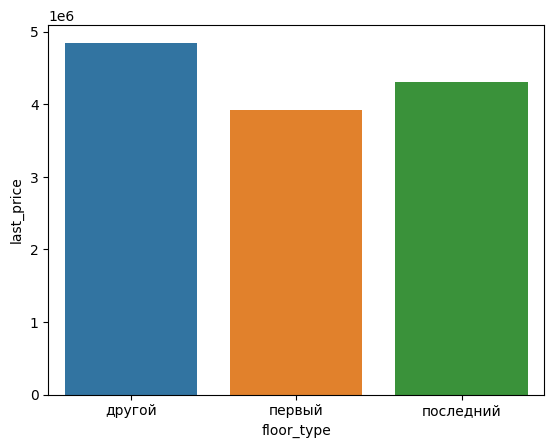

In [77]:
temp = data.pivot_table(index='floor_type', values='last_price', aggfunc='median')
temp['floor_type'] = temp.index.get_level_values(0)

seaborn.barplot(data=temp, y='last_price', x='floor_type')
plt.show()

**Вывод:** Самые дорогие квартиры - на всех этажах кроме первого и последнего, а самые дешевые - на первом этаже.

##### Проанализируем зависимость полной цены квартиры от дат размещения.

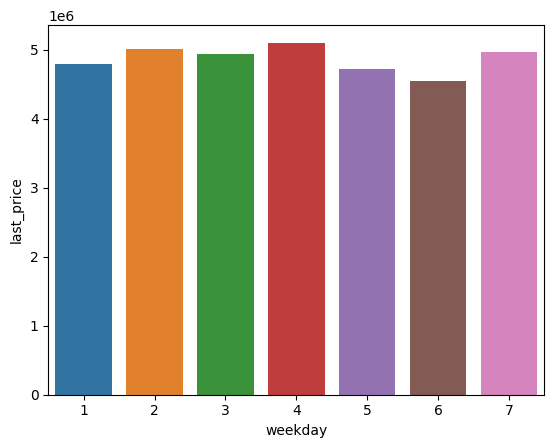

In [78]:
index = ['weekday','month','year']
temp = data.pivot_table(index=index, values=['last_price'], aggfunc='median')
def index_glv(index, level):
    temp[index] = temp.index.get_level_values(level)
for i in index:
    index_glv(i, index.index(i))

seaborn.barplot(data=temp, y='last_price', x='weekday', ci=None)
plt.show()

**Вывод:** Цена квартир в объявлениях зависит от дня недели. Самые дорогие квартиры в объявлениях, размещенных в четверг и воскресенье. А самые дешевые варианты появляются в субботу.

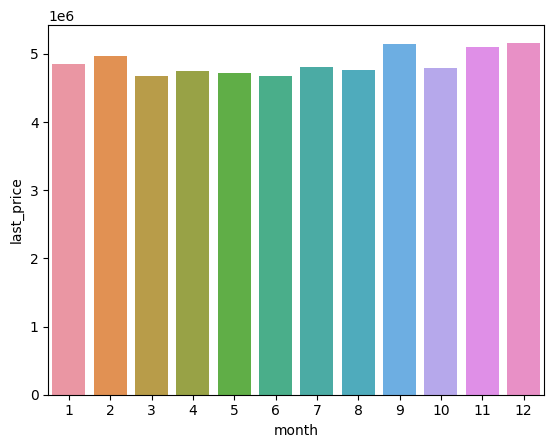

In [79]:
#для month
seaborn.barplot(data=temp, y='last_price', x='month', ci=None)
plt.show()

**Вывод:** Пиковая цена на квартиры в сентябре и зимой. А если хочется купить квартиру подешевле - лучшее время с начала весны до середины лета.

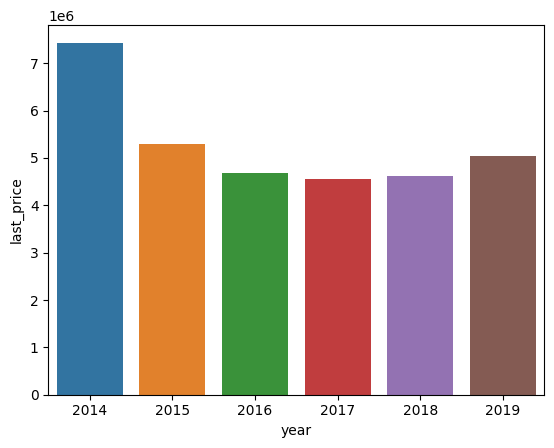

In [80]:
#для year
seaborn.barplot(data=temp, y='last_price', x='year', ci=None)
plt.show()

**Вывод:** Цена на квартиры значительно упала с 2014 по 2017 годы (самое больше падение в 2014) - а с 2018 понемногу растет.

#####  Промежуточный вывод:

По результатам исследования можно с уверенностью сказать, что все исследуемые факторы оказывают влияние на цену квартиры.\
Подробности указаны в выводах после каждой диаграммы в ходе исследования.

#### Расчёт средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [81]:
#выведем сводную таблицу. Индексом выступает имя населенного пункта. Пропусков в столце 'meter_price' нет, считаем вхождения
#и медиану. Отсортируем по кол-ву объявлений, далее извлечем 10 строк, еще раз отсортируем - уже по цене. 
#и преобразуем в читабельный вид.
data.pivot_table(index='locality_name',values='meter_price',aggfunc=['count','median'])\
.droplevel(level=1, axis=1).sort_values(by='count', ascending=False).head(10).sort_values(by='median', ascending=False)\
.rename(columns={'count':'Объявлений','median':'Средняя цена кв.м.'}).rename_axis('Населенный пункт')

,Объявлений,Средняя цена кв.м.
Населенный пункт,,
Санкт-Петербург,15054,"104,148.38500000001"
Пушкин,358,"99,865.715"
поселок Парголово,323,"91,642.86"
деревня Кудрово,268,"91,293.4"
поселок Мурино,483,"83,018.87"
поселок Шушары,428,"76,573.505"
Колпино,335,"74,722.22"
Гатчина,298,"67,746.285"
Всеволожск,386,"65,789.47"


**Вывод:** В первой "десятке" по количеству объявлений самая дорогая недвижимость - в Санкт-Петербурге, средняя цена 127678 за кв.м.\
А самая дешевая - в Всеволожске, средняя цена 65811 за кв.м.


#### Зависимость стоимости объектов от расстояния до центра города Санкт-Петербург

Вычислим среднюю цену каждого км до центра города в Санкт-Петербурге. Далее опишем зависимость стоимости квартир от расстояния до центра города.

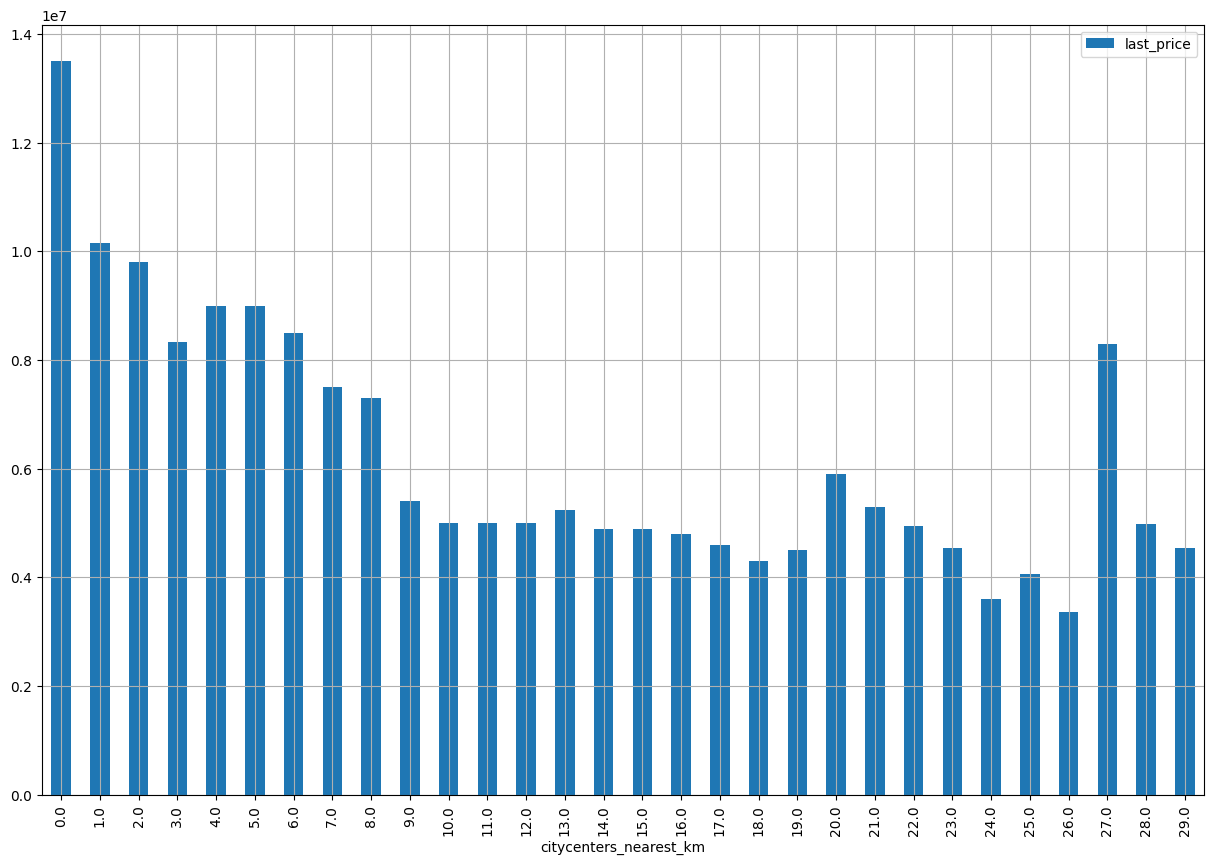

In [82]:
data.query('locality_name == "Санкт-Петербург"')\
.pivot_table(index='cityсenters_nearest_km', values='last_price', aggfunc='median')\
.plot(kind='bar', figsize=(15, 10), grid=True);

**Вывод:** Чем дальше от центра - тем дешевле квартиры, но после 10 км падение цены практически останавливается.\
Есть небольшие выбросы.

In [83]:
data.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityсenters_nearest_km', values='last_price', aggfunc='count')

,last_price
cityсenters_nearest_km,
0.0,22
1.0,166
2.0,281
3.0,328
4.0,646
5.0,846
6.0,565
7.0,394
8.0,568


Причина выброса на 27 км (и на других) - мало данных.

### Общий вывод

В ходе исследования было исключено минимальное количество данных из датафрейма, с целью сохранения общего представления о рынке недвижимости Санкт-Петербурга и области. Из-за этого появились единичные выбросы, но сохранены все данные о квартирах, в т.ч. как о дешевых квартирах малой площади, так и о жилье элитного уровня.

В Санкт-Петербурге и области разнообразный жилой фонд, от студий минимальной площади, до огромных многокомнатных квартир.
Чаще всего встречаются квартиры:
- площадью 25-70 кв.м.
- 1,2,3х комнатные
- цена от 1 до 10 млн (самая популярная - 4 млн)
- высота потолков 2.7 м.

Дома, в которых продаются квартиры:
- в основном 5 этажные, чуть меньше 9 этажных и еще меньше домов большей этажности
- находятся на отдалении 10-17 км от центра города


**На этапе предобработки выяснено,** что пользователи зачастую не заполняют площадь кухни, жилую, и высоту потолков.
Много пропусков обнаружено в данных о балконах и является ли квартира студией.
Также обнаружена нехватка картографических данных по многим объектам.

**При исследовании выяснено:**

В среднем квартиры продаются за 180 дней.

Самая дорогая цена за 1 кв.м. в Санкт-Петербурге. Она составляет 104.000 ден.ед.

Основные факторы, влияющие на цену квартиры:
- общая площадь, чем больше - тем квартира дороже. Жилая площадь влияет на цену уже меньше, а площадь кухни - совсем незначительно.
- удаленность от центра города - квартиры в центре дороже, на окраинах дешевле, но после 10 км отдаления от центра падение цены замедляется.
- с увеличением числа комнат цена растет, однако это происходит до достижения 7 комнат.
- влияние этажа (первый, последний или другой) также имеет значение.
- квартиры стоят дороже всего в сентябре и зимой, а дешевле - весной и до середины лета.
- жилье площадью сильно подешевело начиная с 2014 года, но в 2018 начался небольшой рост.

    